In [228]:
import json
import pandas as pd
from sklearn.decomposition import PCA

def dim_reduction(n_components, embedding_dict): # input: dict; output: dict
    keys = list(embedding_dict.keys())
    embeddings = list(embedding_dict.values())
    pca = PCA(n_components=n_components)
    pca_embeddings = pca.fit_transform(embeddings).tolist()
    pca_embedding_dict = dict(zip(keys, pca_embeddings))
    return pca_embedding_dict

book_df = pd.read_excel('Book.xlsx')
book_test_df = pd.read_excel('Book_test.xlsx')
with open('book_embedding.json', 'r') as f:
    diction = json.load(f)

dim = 1536
# diction = dim_reduction(dim, diction)

df = book_df
df['tags_emotion'] = df['tags_emotion'].map(diction)
df = df[['tags_emotion', 'label']]
df = df.dropna()

df_test = book_test_df
book_test_df['tags_emotion'] = book_test_df['tags_emotion'].map(diction)

In [218]:
df.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)
train_data = df
test_data = df_test
X_train = list(train_data['tags_emotion'])
y_train = train_data['label'].values

In [219]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([64, 1536]), torch.Size([64]))

In [220]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class EmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EmotionClassifier, self).__init__()
        # Define two hidden layers and an output layer
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out


model = EmotionClassifier(input_size=dim, hidden_size=64, num_classes=11)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
model


EmotionClassifier(
  (layer1): Linear(in_features=1536, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=11, bias=True)
)

In [221]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):

    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        # print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval() 
        with torch.no_grad():
            val_running_loss = 0.0
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        # print(f'Validation Loss: {epoch_val_loss:.4f}')

        model.train()

    print('Finished Training')
    return train_losses, val_losses

# Train the model
num_epochs = 50
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Finished Training


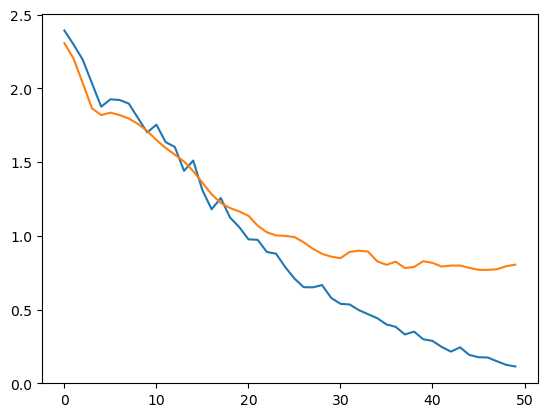

In [222]:
import matplotlib.pyplot as plt
E = range(num_epochs)
plt.plot(E, train_losses)
plt.plot(E, val_losses)
plt.show()

In [223]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

test_features_tensor = torch.tensor(list(test_data['tags_emotion'])).float()
test_features_tensor = torch.tensor(scaler.fit_transform(test_features_tensor), dtype=torch.float32)

model.eval()

with torch.no_grad():
    raw_predictions = model(test_features_tensor)
    probabilities = torch.softmax(raw_predictions, dim=1)
    _, predicted_labels = torch.max(probabilities, 1)

predicted_labels
predicted_labels = predicted_labels.tolist()

In [225]:
df_test['predicted'] = pd.Series(predicted_labels)
tuple_pca_embedding_dict = {k: tuple(v) for k, v in diction.items()}
inverse_pca_embedding_dict = {v: k for k, v in tuple_pca_embedding_dict.items()}
df_test['tags_emotion'] = df_test['tags_emotion'].apply(lambda x: inverse_pca_embedding_dict[tuple(x)] if tuple(x) in inverse_pca_embedding_dict else None)
diction2 = {1:'搞笑组', 2:'情绪组', 3:'害怕组', 4:'正能量组', 5:'负能量组', 6:'烂片组', 7:'励志组', 8:'荒诞组', 9:'思考组', 10:'经典组'}
df_test['predicted'] = df_test['predicted'].map(diction2)
df_test.sort_values('predicted').head(50)

,tags_emotion,predicted
146,None,励志组
150,None,励志组
127,None,励志组
107,None,励志组
91,None,励志组
56,None,励志组
55,None,励志组
67,None,励志组
23,None,励志组
68,None,励志组


In [216]:
df_test.sort_values('predicted').to_excel('Book_output_50epo.xlsx', index=False)